In [75]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import os
import joblib
import numpy as np

In [76]:
print("Tentando baixar 'punkt_tab'...")
nltk.download('punkt_tab')
print("Tentando baixar 'stopwords'...")
nltk.download('stopwords')

Tentando baixar 'punkt_tab'...
Tentando baixar 'stopwords'...


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
# Download do NLTK (só na primeira vez)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
# Configurações gerais
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. CARREGAR E ENTENDER OS DADOS

In [79]:
print("Carregando dataset completo em partes...")
chunksize = 100000  # Processar em lotes de 100.000 linhas
data_chunks = []
for chunk in pd.read_csv('complaints.csv', chunksize=chunksize):
    chunk = chunk.dropna(subset=["narrative"])
    data_chunks.append(chunk)
data = pd.concat(data_chunks, ignore_index=True)

print("Primeiras 5 linhas do dataset:")
print(data.head())
print("\nInformações do dataset:")
print(data.info())

Carregando dataset completo em partes...
Primeiras 5 linhas do dataset:
   Unnamed: 0         product_5  \
0         234  Credit Reporting   
1         240   Debt Collection   
2         257  Credit Reporting   
3         271  Credit Reporting   
4         276             Loans   

                                           narrative  \
0  Dear Possible Financial Inc you guyss aree rep...   
1  XXXX XXXX XXXX ( debt collector ), sent my boy...   
2  I been receiving alerts my information was fou...   
3  Subject : Dispute of Inaccurate Information on...   
4  They allowed me to use the account for about a...   

                                             Product Date received  \
0  Credit reporting or other personal consumer re...    2024-07-27   
1                                    Debt collection    2024-07-27   
2  Credit reporting or other personal consumer re...    2024-07-23   
3  Credit reporting or other personal consumer re...    2024-07-27   
4  Payday loan, title loan, pe

In [80]:
# Características
print("- Origem: Consumer Financial Protection Bureau (CFPB), EUA.")
data["Date received"] = pd.to_datetime(data["Date received"])
print(f"- Periodo: de {data['Date received'].min()} a {data['Date received'].max()}")
print("- Gênero: Reclamações textuais de consumidores sobre serviços financeiros.")
print("- Língua: Inglês.")
print("- Anotação: Rótulos ('Product') atribuídos pelos consumidores ao submeter reclamações.")
print(f"- Total de reclamações: {len(data)}")
print(f"- Colunas disponíveis: {list(data.columns)}")
data = data.dropna(subset=["narrative"])
print(f"\nTotal de reclamações: {len(data)}")

- Origem: Consumer Financial Protection Bureau (CFPB), EUA.
- Periodo: de 2015-03-19 00:00:00 a 2024-07-31 00:00:00
- Gênero: Reclamações textuais de consumidores sobre serviços financeiros.
- Língua: Inglês.
- Anotação: Rótulos ('Product') atribuídos pelos consumidores ao submeter reclamações.
- Total de reclamações: 2023066
- Colunas disponíveis: ['Unnamed: 0', 'product_5', 'narrative', 'Product', 'Date received', 'Sub-product', 'Issue', 'Sub-issue', 'Company', 'State', 'Timely response?']

Total de reclamações: 2023066


## 1.1 Seleção Balanceada: 10.000 exemplos por classe (total 50.000)

In [81]:
n_samples_per_class = 10000
classes = data["product_5"].unique()
balanced_data = []

for class_name in classes:
    class_data = data[data["product_5"] == class_name]
    if len(class_data) < n_samples_per_class:
        print(f"Aviso: Classe '{class_name}' tem apenas {len(class_data)} exemplos, usando todos.")
        balanced_data.append(class_data)
    else:
        class_sample = class_data.sample(n=n_samples_per_class, random_state=42)
        balanced_data.append(class_sample)

In [82]:
# Concatenar os dados balanceados
data_balanced = pd.concat(balanced_data, ignore_index=True)
print("\nDistribuição das classes após seleção balanceada:")
print(data_balanced["product_5"].value_counts())
print(f"Total de exemplos: {len(data_balanced)}")


Distribuição das classes após seleção balanceada:
product_5
Credit Reporting              10000
Debt Collection               10000
Loans                         10000
Bank Accounts and Services    10000
Credit Card Services          10000
Name: count, dtype: int64
Total de exemplos: 50000


# 2. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [83]:
# a) Distribuição de classes
print("\n### Distribuição das Classes (Produtos) ###")
class_counts = data_balanced["product_5"].value_counts()
print(class_counts)
print(class_counts / len(data_balanced))  # Proporção


### Distribuição das Classes (Produtos) ###
product_5
Credit Reporting              10000
Debt Collection               10000
Loans                         10000
Bank Accounts and Services    10000
Credit Card Services          10000
Name: count, dtype: int64
product_5
Credit Reporting              0.2
Debt Collection               0.2
Loans                         0.2
Bank Accounts and Services    0.2
Credit Card Services          0.2
Name: count, dtype: float64


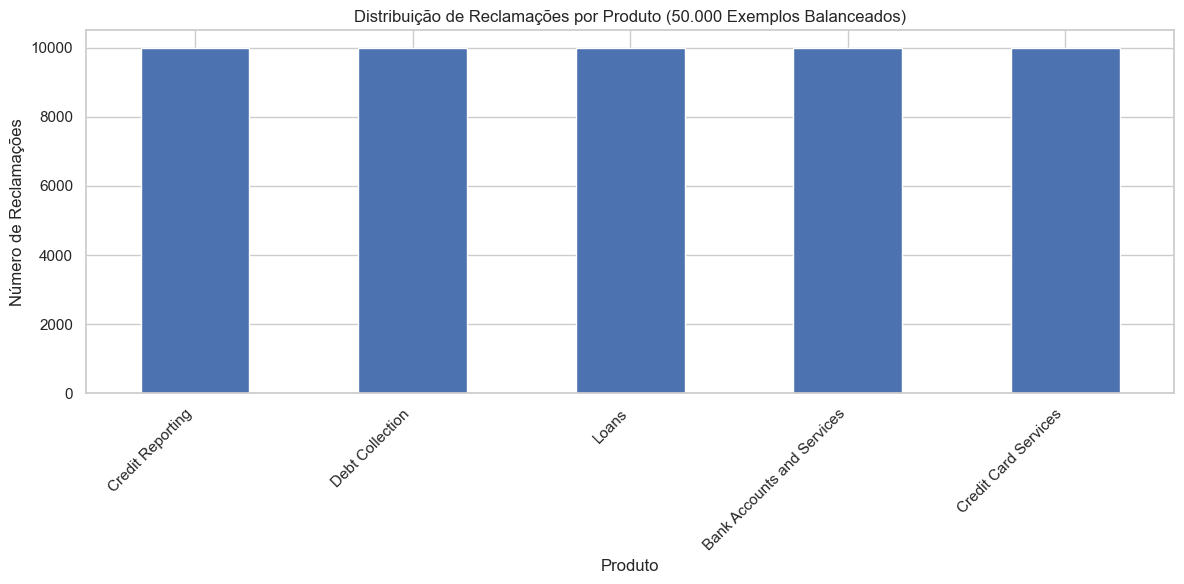

In [84]:
# Gráfico de barras
plt.figure()
class_counts.plot(kind="bar")
plt.title("Distribuição de Reclamações por Produto (50.000 Exemplos Balanceados)")
plt.xlabel("Produto")
plt.ylabel("Número de Reclamações")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [85]:
# Pré-processamento
ps = PorterStemmer()
sw = set(stopwords.words("english"))

In [86]:
# b) Pré-processamento (remover não alfabéticos, stopwords, converter para minúsculas, stemming)
if "processed_text_stemmed" not in data_balanced.columns or not os.path.exists("consumer_complaints_processed_50000.csv"):
    print("Pré-processando dataset balanceado...")
    corpus = []
    for review in data_balanced["narrative"]:
        # Feito como no notebook "Text Classification with Traditional ML" (conversão para minúsculas, remoção de caracteres especiais e stopwords)
        review = re.sub('[^a-zA-Z]', ' ', str(review)).lower()
        tokens = [ps.stem(w) for w in review.split() if w not in sw]
        corpus.append(' '.join(tokens))
    data_balanced["processed_text_stemmed"] = corpus
    data_balanced.to_csv("consumer_complaints_processed_50000.csv", index=False)
    print("Corpus processado criado e salvo como 'consumer_complaints_processed_50000.csv'.")
else:
    data_balanced = pd.read_csv("consumer_complaints_processed_50000.csv")
    print("Carregando corpus processado salvo...")

Pré-processando dataset balanceado...


Corpus processado criado e salvo como 'consumer_complaints_processed_50000.csv'.


In [87]:
# c) Comprimento das reclamações
data_balanced["word_count"] = data_balanced["processed_text_stemmed"].apply(lambda x: len(word_tokenize(str(x))))
print("\n### Estatísticas do Comprimento das Reclamações ###")
print(data_balanced["word_count"].describe())


### Estatísticas do Comprimento das Reclamações ###
count    50000.000000
mean       104.174780
std        121.686658
min          0.000000
25%         36.000000
50%         71.000000
75%        128.250000
max       3025.000000
Name: word_count, dtype: float64


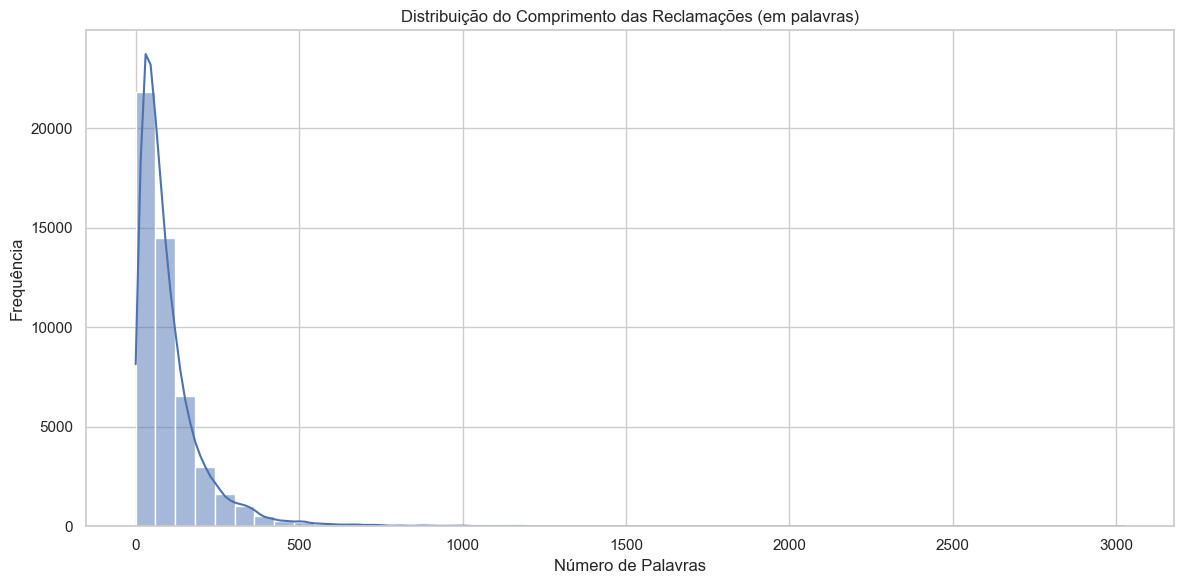

In [88]:
# Histograma
plt.figure()
sns.histplot(data_balanced["word_count"], bins=50, kde=True)
plt.title("Distribuição do Comprimento das Reclamações (em palavras)")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

In [89]:
# d) Análise de vocabulário com CountVectorizer
vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(data_balanced["processed_text_stemmed"]).toarray()
vocab = vectorizer.get_feature_names_out()

In [90]:
# Cria custom_stopwords
custom_stopwords = set(stopwords.words("english")) | {word for word in vocab if all(c == 'x' for c in word.lower())}
vectorizer = CountVectorizer(max_features=20, stop_words=list(custom_stopwords))
X = vectorizer.fit_transform(data_balanced["processed_text_stemmed"]).toarray()
vocab = vectorizer.get_feature_names_out()
print("\n### Top 20 Palavras no Vocabulário (Bag-of-Words, sem tokens de 'x') ###")
print(vocab)


### Top 20 Palavras no Vocabulário (Bag-of-Words, sem tokens de 'x') ###
['account' 'bank' 'call' 'card' 'charg' 'check' 'compani' 'consum'
 'credit' 'day' 'debt' 'inform' 'loan' 'payment' 'receiv' 'report' 'state'
 'time' 'told' 'would']


In [91]:
# e) N-gramas mais frequentes
bigram_counts = Counter()
batch_size = 10000
for i in range(0, len(data_balanced["processed_text_stemmed"]), batch_size):
    batch_corpus = data_balanced["processed_text_stemmed"][i:i + batch_size].astype(str).tolist()
    all_tokens = " ".join(batch_corpus).split()
    # bigrams = ngrams(all_tokens, 2)
    bigrams = (bigram for bigram in ngrams(all_tokens, 2)
               if not any(all(c == 'x' for c in str(w).lower()) for w in bigram)
               and ' '.join(bigram) != 'u c')
    bigram_counts.update(bigrams)

In [92]:
# Os 10 bigramas mais frequentes
bigram_counts = bigram_counts.most_common(10)
print("\n### Top 10 Bigramas Mais Frequentes ###")
for bigram, count in bigram_counts:
    print(f"{' '.join(bigram)}: {count}")


### Top 10 Bigramas Mais Frequentes ###
credit report: 22609
credit card: 12548
consum report: 7728
well fargo: 6414
report agenc: 6078
custom servic: 5518
credit bureau: 5270
bank america: 5076
check account: 4817
ident theft: 4464


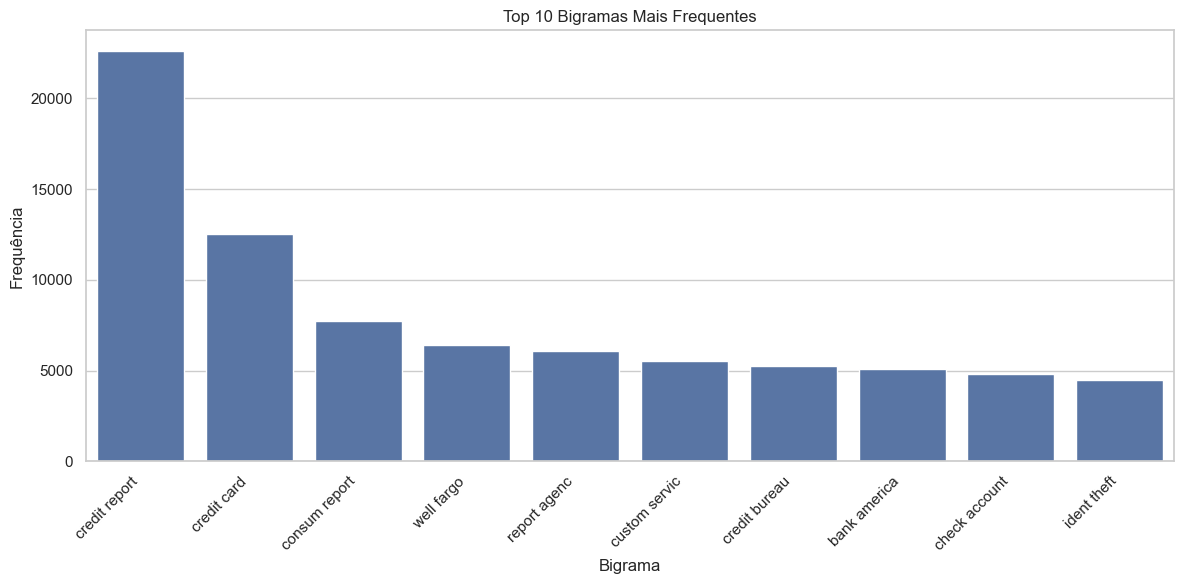

In [93]:
# Gráfico de barras para bigramas
bigram_labels = [" ".join(bigram[0]) for bigram in bigram_counts]
bigram_values = [bigram[1] for bigram in bigram_counts]
plt.figure()
sns.barplot(x=bigram_labels, y=bigram_values)
plt.title("Top 10 Bigramas Mais Frequentes")
plt.xlabel("Bigrama")
plt.ylabel("Frequência")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3. CLASSIFICADORES

In [94]:
# Bag-of-Words com CountVectorizer
vectorizer = CountVectorizer(max_features=2000, stop_words=list(custom_stopwords))
X = vectorizer.fit_transform(data_balanced["processed_text_stemmed"])
print(f"Tamanho do espaço de features (BoW): {X.shape[1]} features")

Tamanho do espaço de features (BoW): 2000 features


In [95]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, data_balanced["product_5"], test_size=0.2, random_state=42)

## 3.1 - Classificadores com Bag-of-Words

In [96]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes com BoW:\n", classification_report(y_test, y_pred_nb, zero_division=0))
joblib.dump(nb, 'naive_bayes_bow_50000.joblib')

Naive Bayes com BoW:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.88      0.87      1998
      Credit Card Services       0.79      0.75      0.77      1950
          Credit Reporting       0.73      0.83      0.78      2043
           Debt Collection       0.79      0.67      0.73      1993
                     Loans       0.84      0.86      0.85      2016

                  accuracy                           0.80     10000
                 macro avg       0.80      0.80      0.80     10000
              weighted avg       0.80      0.80      0.80     10000



['naive_bayes_bow_50000.joblib']

In [97]:
# Logistic Regression com diferentes regularizações
# L2 Regularization
lr_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='liblinear')
lr_l2.fit(X_train, y_train)
y_pred_lr_l2 = lr_l2.predict(X_test)
print("Logistic Regression (L2) com BoW:\n", classification_report(y_test, y_pred_lr_l2, zero_division=0))
print(f"Features ativas (L2): {(lr_l2.coef_ != 0).sum()}")
joblib.dump(lr_l2, 'logistic_regression_l2_bow_50000.joblib')

Logistic Regression (L2) com BoW:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.85      0.87      0.86      1998
      Credit Card Services       0.81      0.80      0.80      1950
          Credit Reporting       0.79      0.82      0.81      2043
           Debt Collection       0.78      0.78      0.78      1993
                     Loans       0.87      0.83      0.85      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000

Features ativas (L2): 10000


['logistic_regression_l2_bow_50000.joblib']

In [98]:
# L1 Regularization
lr_l1 = LogisticRegression(penalty='l1', C=1.0, max_iter=1000, solver='liblinear')
lr_l1.fit(X_train, y_train)
y_pred_lr_l1 = lr_l1.predict(X_test)
print("Logistic Regression (L1) com BoW:\n", classification_report(y_test, y_pred_lr_l1, zero_division=0))
print(f"Features ativas (L1): {(lr_l1.coef_ != 0).sum()}")
joblib.dump(lr_l1, 'logistic_regression_l1_bow_50000.joblib')

Logistic Regression (L1) com BoW:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.87      0.86      1998
      Credit Card Services       0.81      0.81      0.81      1950
          Credit Reporting       0.80      0.82      0.81      2043
           Debt Collection       0.78      0.78      0.78      1993
                     Loans       0.87      0.83      0.85      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000

Features ativas (L1): 8300


['logistic_regression_l1_bow_50000.joblib']

In [99]:
# Elastic Net
lr_elastic = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, max_iter=1000, solver='saga', tol=1e-2)
lr_elastic.fit(X_train, y_train)
y_pred_lr_elastic = lr_elastic.predict(X_test)
print("Logistic Regression (Elastic Net) com BoW:\n", classification_report(y_test, y_pred_lr_elastic, zero_division=0))
print(f"Features ativas (Elastic Net): {(lr_elastic.coef_ != 0).sum()}")
joblib.dump(lr_elastic, 'logistic_regression_elastic_bow_50000.joblib')

Logistic Regression (Elastic Net) com BoW:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.88      0.87      1998
      Credit Card Services       0.83      0.81      0.82      1950
          Credit Reporting       0.77      0.84      0.80      2043
           Debt Collection       0.79      0.74      0.76      1993
                     Loans       0.87      0.85      0.86      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000

Features ativas (Elastic Net): 9947


['logistic_regression_elastic_bow_50000.joblib']

In [100]:
# SGD Classifier
batch_size = 10000
n_epochs = 10

In [101]:
# SGD com L2
sgd_l2 = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42, early_stopping=False)
best_acc = 0
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs} (SGD L2)")
    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train.iloc[indices] if isinstance(y_train, pd.Series) else y_train[indices]
    for start in range(0, X_train.shape[0], batch_size):
        end = min(start + batch_size, X_train.shape[0])
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]
        if epoch == 0 and start == 0:
            sgd_l2.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        else:
            sgd_l2.partial_fit(X_batch, y_batch)
    y_pred_sgd = sgd_l2.predict(X_test)
    acc = accuracy_score(y_test, y_pred_sgd)
    print(f"Acurácia no teste após época {epoch + 1}: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        joblib.dump(sgd_l2, 'sgd_l2_bow_50000.joblib')
print("SGD Classifier (L2) com BoW:\n", classification_report(y_test, sgd_l2.predict(X_test), zero_division=0))
print(f"Features ativas (SGD L2): {(sgd_l2.coef_ != 0).sum()}")

Epoch 1/10 (SGD L2)
Acurácia no teste após época 1: 0.7498
Epoch 2/10 (SGD L2)
Acurácia no teste após época 2: 0.7977
Epoch 3/10 (SGD L2)
Acurácia no teste após época 3: 0.7935
Epoch 4/10 (SGD L2)
Acurácia no teste após época 4: 0.7968
Epoch 5/10 (SGD L2)
Acurácia no teste após época 5: 0.8017
Epoch 6/10 (SGD L2)
Acurácia no teste após época 6: 0.7926
Epoch 7/10 (SGD L2)
Acurácia no teste após época 7: 0.8070
Epoch 8/10 (SGD L2)
Acurácia no teste após época 8: 0.7815
Epoch 9/10 (SGD L2)
Acurácia no teste após época 9: 0.8052
Epoch 10/10 (SGD L2)
Acurácia no teste após época 10: 0.7954
SGD Classifier (L2) com BoW:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.86      0.85      1998
      Credit Card Services       0.81      0.77      0.79      1950
          Credit Reporting       0.80      0.73      0.77      2043
           Debt Collection       0.71      0.79      0.75      1993
                     Loans       0.83

In [102]:
# SGD com L1
sgd_l1 = SGDClassifier(loss='log_loss', penalty='l1', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42, early_stopping=False)
best_acc = 0
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs} (SGD L1)")
    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train.iloc[indices] if isinstance(y_train, pd.Series) else y_train[indices]
    for start in range(0, X_train.shape[0], batch_size):
        end = min(start + batch_size, X_train.shape[0])
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]
        if epoch == 0 and start == 0:
            sgd_l1.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        else:
            sgd_l1.partial_fit(X_batch, y_batch)
    y_pred_sgd = sgd_l1.predict(X_test)
    acc = accuracy_score(y_test, y_pred_sgd)
    print(f"Acurácia no teste após época {epoch + 1}: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        joblib.dump(sgd_l1, 'sgd_l1_bow_50000.joblib')
print("SGD Classifier (L1) com BoW:\n", classification_report(y_test, sgd_l1.predict(X_test), zero_division=0))
print(f"Features ativas (SGD L1): {(sgd_l1.coef_ != 0).sum()}")

Epoch 1/10 (SGD L1)
Acurácia no teste após época 1: 0.7893
Epoch 2/10 (SGD L1)
Acurácia no teste após época 2: 0.8008
Epoch 3/10 (SGD L1)
Acurácia no teste após época 3: 0.8003
Epoch 4/10 (SGD L1)
Acurácia no teste após época 4: 0.7993
Epoch 5/10 (SGD L1)
Acurácia no teste após época 5: 0.7970
Epoch 6/10 (SGD L1)
Acurácia no teste após época 6: 0.7990
Epoch 7/10 (SGD L1)
Acurácia no teste após época 7: 0.8003
Epoch 8/10 (SGD L1)
Acurácia no teste após época 8: 0.7986
Epoch 9/10 (SGD L1)
Acurácia no teste após época 9: 0.7943
Epoch 10/10 (SGD L1)
Acurácia no teste após época 10: 0.7935
SGD Classifier (L1) com BoW:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.84      0.84      1998
      Credit Card Services       0.74      0.81      0.77      1950
          Credit Reporting       0.80      0.75      0.77      2043
           Debt Collection       0.76      0.74      0.75      1993
                     Loans       0.82

In [103]:
# 3.2 - Classificadores com TF-IDF e N-grams
print("Aplicando TF-IDF com N-grams...")
tfidf_ngrams = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words=list(custom_stopwords))
X_tfidf_ngrams = tfidf_ngrams.fit_transform(data_balanced["processed_text_stemmed"])
print(f"Tamanho do espaço de features com N-grams (TF-IDF): {X_tfidf_ngrams.shape[1]}")
joblib.dump(tfidf_ngrams, 'tfidf_ngrams_vectorizer_50000.joblib')

Aplicando TF-IDF com N-grams...
Tamanho do espaço de features com N-grams (TF-IDF): 2000


['tfidf_ngrams_vectorizer_50000.joblib']

In [104]:
# Divisão treino/teste
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(X_tfidf_ngrams, data_balanced["product_5"], test_size=0.2, random_state=42)

In [105]:
# Naive Bayes com N-grams
nb = MultinomialNB()
nb.fit(X_train_ng, y_train_ng)
y_pred_nb_ng = nb.predict(X_test_ng)
print("Naive Bayes com N-grams e TF-IDF:\n", classification_report(y_test_ng, y_pred_nb_ng, zero_division=0))
joblib.dump(nb, 'naive_bayes_ngrams_tfidf_50000.joblib')

Naive Bayes com N-grams e TF-IDF:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.90      0.86      1998
      Credit Card Services       0.80      0.77      0.78      1950
          Credit Reporting       0.78      0.80      0.79      2043
           Debt Collection       0.79      0.70      0.74      1993
                     Loans       0.83      0.86      0.84      2016

                  accuracy                           0.81     10000
                 macro avg       0.81      0.81      0.80     10000
              weighted avg       0.80      0.81      0.80     10000



['naive_bayes_ngrams_tfidf_50000.joblib']

In [106]:
# Logistic Regression com N-grams
# L2 Regularization
lr_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='liblinear')
lr_l2.fit(X_train_ng, y_train_ng)
y_pred_lr_l2 = lr_l2.predict(X_test_ng)
print("Logistic Regression (L2) com TF-IDF e N-grams:\n", classification_report(y_test_ng, y_pred_lr_l2, zero_division=0))
print(f"Features ativas (L2): {(lr_l2.coef_ != 0).sum()}")
joblib.dump(lr_l2, 'logistic_regression_l2_ngrams_tfidf_50000.joblib')

Logistic Regression (L2) com TF-IDF e N-grams:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.88      0.90      0.89      1998
      Credit Card Services       0.84      0.84      0.84      1950
          Credit Reporting       0.82      0.83      0.82      2043
           Debt Collection       0.81      0.78      0.80      1993
                     Loans       0.87      0.87      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000

Features ativas (L2): 10000


['logistic_regression_l2_ngrams_tfidf_50000.joblib']

In [107]:
# L1 Regularization
lr_l1 = LogisticRegression(penalty='l1', C=1.0, max_iter=1000, solver='liblinear')
lr_l1.fit(X_train_ng, y_train_ng)
y_pred_lr_l1 = lr_l1.predict(X_test_ng)
print("Logistic Regression (L1) com TF-IDF e N-grams:\n", classification_report(y_test_ng, y_pred_lr_l1, zero_division=0))
print(f"Features ativas (L1): {(lr_l1.coef_ != 0).sum()}")
joblib.dump(lr_l1, 'logistic_regression_l1_ngrams_tfidf_50000.joblib')

Logistic Regression (L1) com TF-IDF e N-grams:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.88      0.89      0.89      1998
      Credit Card Services       0.84      0.85      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.81      0.78      0.79      1993
                     Loans       0.87      0.87      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000

Features ativas (L1): 3450


['logistic_regression_l1_ngrams_tfidf_50000.joblib']

In [108]:
# Elastic Net
lr_elastic = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, max_iter=1000, solver='saga', tol=1e-2)
lr_elastic.fit(X_train_ng, y_train_ng)
y_pred_lr_elastic = lr_elastic.predict(X_test_ng)
print("Logistic Regression (Elastic Net) com TF-IDF e N-grams:\n", classification_report(y_test_ng, y_pred_lr_elastic, zero_division=0))
print(f"Features ativas (Elastic Net): {(lr_elastic.coef_ != 0).sum()}")
joblib.dump(lr_elastic, 'logistic_regression_elastic_ngrams_tfidf_50000.joblib')

Logistic Regression (Elastic Net) com TF-IDF e N-grams:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.89      0.89      1998
      Credit Card Services       0.84      0.84      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.81      0.78      0.79      1993
                     Loans       0.87      0.87      0.87      2016

                  accuracy                           0.84     10000
                 macro avg       0.84      0.84      0.84     10000
              weighted avg       0.84      0.84      0.84     10000

Features ativas (Elastic Net): 6031


['logistic_regression_elastic_ngrams_tfidf_50000.joblib']

In [109]:
# SGD Classifier com N-grams
# SGD com L2
sgd_l2 = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42, early_stopping=False)
best_acc = 0
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs} (SGD L2)")
    indices = np.random.permutation(X_train_ng.shape[0])
    X_train_shuffled = X_train_ng[indices]
    y_train_shuffled = y_train_ng.iloc[indices] if isinstance(y_train_ng, pd.Series) else y_train_ng[indices]
    for start in range(0, X_train_ng.shape[0], batch_size):
        end = min(start + batch_size, X_train_ng.shape[0])
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]
        if epoch == 0 and start == 0:
            sgd_l2.partial_fit(X_batch, y_batch, classes=np.unique(y_train_ng))
        else:
            sgd_l2.partial_fit(X_batch, y_batch)
    y_pred_sgd = sgd_l2.predict(X_test_ng)
    acc = accuracy_score(y_test_ng, y_pred_sgd)
    print(f"Acurácia no teste após época {epoch + 1}: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        joblib.dump(sgd_l2, 'sgd_l2_ngrams_tfidf_50000.joblib')
print("SGD Classifier (L2) com TF-IDF e N-grams:\n", classification_report(y_test_ng, sgd_l2.predict(X_test_ng), zero_division=0))
print(f"Features ativas (SGD L2): {(sgd_l2.coef_ != 0).sum()}")

Epoch 1/10 (SGD L2)
Acurácia no teste após época 1: 0.8393
Epoch 2/10 (SGD L2)
Acurácia no teste após época 2: 0.8413
Epoch 3/10 (SGD L2)
Acurácia no teste após época 3: 0.8417
Epoch 4/10 (SGD L2)
Acurácia no teste após época 4: 0.8424
Epoch 5/10 (SGD L2)
Acurácia no teste após época 5: 0.8417
Epoch 6/10 (SGD L2)
Acurácia no teste após época 6: 0.8422
Epoch 7/10 (SGD L2)
Acurácia no teste após época 7: 0.8409
Epoch 8/10 (SGD L2)
Acurácia no teste após época 8: 0.8423
Epoch 9/10 (SGD L2)
Acurácia no teste após época 9: 0.8425
Epoch 10/10 (SGD L2)
Acurácia no teste após época 10: 0.8421
SGD Classifier (L2) com TF-IDF e N-grams:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.88      0.90      0.89      1998
      Credit Card Services       0.84      0.84      0.84      1950
          Credit Reporting       0.81      0.83      0.82      2043
           Debt Collection       0.81      0.77      0.79      1993
                     Loa

In [110]:
# SGD com L1
sgd_l1 = SGDClassifier(loss='log_loss', penalty='l1', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42, early_stopping=False)
best_acc = 0
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs} (SGD L1)")
    indices = np.random.permutation(X_train_ng.shape[0])
    X_train_shuffled = X_train_ng[indices]
    y_train_shuffled = y_train_ng.iloc[indices] if isinstance(y_train_ng, pd.Series) else y_train_ng[indices]
    for start in range(0, X_train_ng.shape[0], batch_size):
        end = min(start + batch_size, X_train_ng.shape[0])
        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]
        if epoch == 0 and start == 0:
            sgd_l1.partial_fit(X_batch, y_batch, classes=np.unique(y_train_ng))
        else:
            sgd_l1.partial_fit(X_batch, y_batch)
    y_pred_sgd = sgd_l1.predict(X_test_ng)
    acc = accuracy_score(y_test_ng, y_pred_sgd)
    print(f"Acurácia no teste após época {epoch + 1}: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        joblib.dump(sgd_l1, 'sgd_l1_ngrams_tfidf_50000.joblib')
print("SGD Classifier (L1) com TF-IDF e N-grams:\n", classification_report(y_test_ng, sgd_l1.predict(X_test_ng), zero_division=0))
print(f"Features ativas (SGD L1): {(sgd_l1.coef_ != 0).sum()}")

Epoch 1/10 (SGD L1)
Acurácia no teste após época 1: 0.8379
Epoch 2/10 (SGD L1)
Acurácia no teste após época 2: 0.8391
Epoch 3/10 (SGD L1)
Acurácia no teste após época 3: 0.8386
Epoch 4/10 (SGD L1)
Acurácia no teste após época 4: 0.8381
Epoch 5/10 (SGD L1)
Acurácia no teste após época 5: 0.8388
Epoch 6/10 (SGD L1)
Acurácia no teste após época 6: 0.8386
Epoch 7/10 (SGD L1)
Acurácia no teste após época 7: 0.8383
Epoch 8/10 (SGD L1)
Acurácia no teste após época 8: 0.8389
Epoch 9/10 (SGD L1)
Acurácia no teste após época 9: 0.8383
Epoch 10/10 (SGD L1)
Acurácia no teste após época 10: 0.8382
SGD Classifier (L1) com TF-IDF e N-grams:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.87      0.89      0.88      1998
      Credit Card Services       0.83      0.85      0.84      1950
          Credit Reporting       0.81      0.82      0.82      2043
           Debt Collection       0.81      0.77      0.79      1993
                     Loa

In [111]:
# 3.3 - Normalização com StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_ng_scaled = scaler.fit_transform(X_train_ng)
X_test_ng_scaled = scaler.transform(X_test_ng)

In [112]:
# Naive Bayes com N-grams (normalizado)
nb = MultinomialNB()
nb.fit(X_train_ng_scaled, y_train_ng)
y_pred_nb_ng = nb.predict(X_test_ng_scaled)
print("Naive Bayes com N-grams e TF-IDF normalizado:\n", classification_report(y_test_ng, y_pred_nb_ng, zero_division=0))
joblib.dump(nb, 'naive_bayes_ngrams_tfidf_normalized_50000.joblib')

Naive Bayes com N-grams e TF-IDF normalizado:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.81      0.89      0.85      1998
      Credit Card Services       0.77      0.74      0.75      1950
          Credit Reporting       0.80      0.76      0.78      2043
           Debt Collection       0.75      0.72      0.74      1993
                     Loans       0.81      0.84      0.83      2016

                  accuracy                           0.79     10000
                 macro avg       0.79      0.79      0.79     10000
              weighted avg       0.79      0.79      0.79     10000



['naive_bayes_ngrams_tfidf_normalized_50000.joblib']

In [113]:
# Logistic Regression com N-grams (normalizado)
# L2 Regularization
lr_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='liblinear')
lr_l2.fit(X_train_ng_scaled, y_train_ng)
y_pred_lr_l2 = lr_l2.predict(X_test_ng_scaled)
print("Logistic Regression (L2) com TF-IDF e N-grams normalizado:\n", classification_report(y_test_ng, y_pred_lr_l2, zero_division=0))
print(f"Features ativas (L2): {(lr_l2.coef_ != 0).sum()}")
joblib.dump(lr_l2, 'logistic_regression_l2_ngrams_tfidf_normalized_50000.joblib')

Logistic Regression (L2) com TF-IDF e N-grams normalizado:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.87      0.87      0.87      1998
      Credit Card Services       0.83      0.83      0.83      1950
          Credit Reporting       0.81      0.82      0.82      2043
           Debt Collection       0.79      0.78      0.78      1993
                     Loans       0.86      0.85      0.85      2016

                  accuracy                           0.83     10000
                 macro avg       0.83      0.83      0.83     10000
              weighted avg       0.83      0.83      0.83     10000

Features ativas (L2): 10000


['logistic_regression_l2_ngrams_tfidf_normalized_50000.joblib']

In [114]:
# L1 Regularization
lr_l1 = LogisticRegression(penalty='l1', C=1.0, max_iter=1000, solver='liblinear')
lr_l1.fit(X_train_ng_scaled, y_train_ng)
y_pred_lr_l1 = lr_l1.predict(X_test_ng_scaled)
print("Logistic Regression (L1) com TF-IDF e N-grams normalizado:\n", classification_report(y_test_ng, y_pred_lr_l1, zero_division=0))
print(f"Features ativas (L1): {(lr_l1.coef_ != 0).sum()}")
joblib.dump(lr_l1, 'logistic_regression_l1_ngrams_tfidf_normalized_50000.joblib')

Logistic Regression (L1) com TF-IDF e N-grams normalizado:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.87      0.88      0.87      1998
      Credit Card Services       0.83      0.83      0.83      1950
          Credit Reporting       0.82      0.82      0.82      2043
           Debt Collection       0.79      0.79      0.79      1993
                     Loans       0.86      0.85      0.85      2016

                  accuracy                           0.83     10000
                 macro avg       0.83      0.83      0.83     10000
              weighted avg       0.83      0.83      0.83     10000

Features ativas (L1): 9732


['logistic_regression_l1_ngrams_tfidf_normalized_50000.joblib']

In [115]:
# Elastic Net
lr_elastic = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, max_iter=1000, solver='saga', tol=1e-2)
lr_elastic.fit(X_train_ng_scaled, y_train_ng)
y_pred_lr_elastic = lr_elastic.predict(X_test_ng_scaled)
print("Logistic Regression (Elastic Net) com TF-IDF e N-grams normalizado:\n", classification_report(y_test_ng, y_pred_lr_elastic, zero_division=0))
print(f"Features ativas (Elastic Net): {(lr_elastic.coef_ != 0).sum()}")
joblib.dump(lr_elastic, 'logistic_regression_elastic_ngrams_tfidf_normalized_50000.joblib')

Logistic Regression (Elastic Net) com TF-IDF e N-grams normalizado:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.87      0.86      0.87      1998
      Credit Card Services       0.81      0.81      0.81      1950
          Credit Reporting       0.80      0.81      0.81      2043
           Debt Collection       0.78      0.78      0.78      1993
                     Loans       0.84      0.83      0.84      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000

Features ativas (Elastic Net): 9982


['logistic_regression_elastic_ngrams_tfidf_normalized_50000.joblib']

In [116]:
# SGD Classifier com N-grams (normalizado)
# SGD com L2
sgd_l2 = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42, early_stopping=False)
best_acc = 0
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs} (SGD L2)")
    indices = np.random.permutation(X_train_ng.shape[0])
    X_train_shuffled = X_train_ng[indices]
    y_train_shuffled = y_train_ng.iloc[indices] if isinstance(y_train_ng, pd.Series) else y_train_ng[indices]
    for start in range(0, X_train_ng.shape[0], batch_size):
        end = min(start + batch_size, X_train_ng.shape[0])
        X_batch = X_train_shuffled[start:end]
        X_batch_scaled = scaler.transform(X_batch)
        y_batch = y_train_shuffled[start:end]
        if epoch == 0 and start == 0:
            sgd_l2.partial_fit(X_batch_scaled, y_batch, classes=np.unique(y_train_ng))
        else:
            sgd_l2.partial_fit(X_batch_scaled, y_batch)
    y_pred_sgd = sgd_l2.predict(X_test_ng_scaled)
    acc = accuracy_score(y_test_ng, y_pred_sgd)
    print(f"Acurácia no teste após época {epoch + 1}: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        joblib.dump(sgd_l2, 'sgd_l2_ngrams_tfidf_normalized_50000.joblib')
print("SGD Classifier (L2) com TF-IDF e N-grams normalizado:\n", classification_report(y_test_ng, sgd_l2.predict(X_test_ng_scaled), zero_division=0))
print(f"Features ativas (SGD L2): {(sgd_l2.coef_ != 0).sum()}")

Epoch 1/10 (SGD L2)
Acurácia no teste após época 1: 0.7809
Epoch 2/10 (SGD L2)
Acurácia no teste após época 2: 0.7838
Epoch 3/10 (SGD L2)
Acurácia no teste após época 3: 0.7927
Epoch 4/10 (SGD L2)
Acurácia no teste após época 4: 0.7972
Epoch 5/10 (SGD L2)
Acurácia no teste após época 5: 0.7898
Epoch 6/10 (SGD L2)
Acurácia no teste após época 6: 0.7973
Epoch 7/10 (SGD L2)
Acurácia no teste após época 7: 0.7887
Epoch 8/10 (SGD L2)
Acurácia no teste após época 8: 0.7882
Epoch 9/10 (SGD L2)
Acurácia no teste após época 9: 0.7868
Epoch 10/10 (SGD L2)
Acurácia no teste após época 10: 0.8011
SGD Classifier (L2) com TF-IDF e N-grams normalizado:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.86      0.84      1998
      Credit Card Services       0.80      0.76      0.78      1950
          Credit Reporting       0.79      0.80      0.79      2043
           Debt Collection       0.76      0.76      0.76      1993
            

In [117]:
# SGD com L1
sgd_l1 = SGDClassifier(loss='log_loss', penalty='l1', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=42, early_stopping=False)
best_acc = 0
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs} (SGD L1)")
    indices = np.random.permutation(X_train_ng.shape[0])
    X_train_shuffled = X_train_ng[indices]
    y_train_shuffled = y_train_ng.iloc[indices] if isinstance(y_train_ng, pd.Series) else y_train_ng[indices]
    for start in range(0, X_train_ng.shape[0], batch_size):
        end = min(start + batch_size, X_train_ng.shape[0])
        X_batch = X_train_shuffled[start:end]
        X_batch_scaled = scaler.transform(X_batch)
        y_batch = y_train_shuffled[start:end]
        if epoch == 0 and start == 0:
            sgd_l1.partial_fit(X_batch_scaled, y_batch, classes=np.unique(y_train_ng))
        else:
            sgd_l1.partial_fit(X_batch_scaled, y_batch)
    y_pred_sgd = sgd_l1.predict(X_test_ng_scaled)
    acc = accuracy_score(y_test_ng, y_pred_sgd)
    print(f"Acurácia no teste após época {epoch + 1}: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        joblib.dump(sgd_l1, 'sgd_l1_ngrams_tfidf_normalized_50000.joblib')
print("SGD Classifier (L1) com TF-IDF e N-grams normalizado:\n", classification_report(y_test_ng, sgd_l1.predict(X_test_ng_scaled), zero_division=0))
print(f"Features ativas (SGD L1): {(sgd_l1.coef_ != 0).sum()}")

Epoch 1/10 (SGD L1)
Acurácia no teste após época 1: 0.8102
Epoch 2/10 (SGD L1)
Acurácia no teste após época 2: 0.8128
Epoch 3/10 (SGD L1)
Acurácia no teste após época 3: 0.8122
Epoch 4/10 (SGD L1)
Acurácia no teste após época 4: 0.8102
Epoch 5/10 (SGD L1)
Acurácia no teste após época 5: 0.8095
Epoch 6/10 (SGD L1)
Acurácia no teste após época 6: 0.8101
Epoch 7/10 (SGD L1)
Acurácia no teste após época 7: 0.8091
Epoch 8/10 (SGD L1)
Acurácia no teste após época 8: 0.8096
Epoch 9/10 (SGD L1)
Acurácia no teste após época 9: 0.8093
Epoch 10/10 (SGD L1)
Acurácia no teste após época 10: 0.8090
SGD Classifier (L1) com TF-IDF e N-grams normalizado:
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.86      0.86      1998
      Credit Card Services       0.79      0.81      0.80      1950
          Credit Reporting       0.79      0.79      0.79      2043
           Debt Collection       0.76      0.77      0.76      1993
            

In [118]:
# Salvar dataset processado
data_balanced.to_csv("consumer_complaints_50000_original.csv", index=False)
print("\nDataset processado salvo como 'consumer_complaints_50000_original.csv'.")


Dataset processado salvo como 'consumer_complaints_50000_original.csv'.
